<a href="https://colab.research.google.com/github/b-fatma/S2I-DM/blob/master/src/3_merge/v2/merge_4_clean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
import geopandas as gpd
import pandas as pd
import csv
import sys
import geopandas as gpd
import shapely
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [11]:
input_path = '/content/drive/MyDrive/dm_fire_prediction/merge/fire_landcover_elevation_no_binning_soil_no_na_climate_int.csv'

df = pd.read_csv(input_path)
df.head()

,longitude,latitude,fire,lcccode_label,elevation,latitude_soil,longitude_soil,COARSE,SAND,SILT,...,prec_summer,prec_winter,tmax_autumn,tmax_spring,tmax_summer,tmax_winter,tmin_autumn,tmin_spring,tmin_summer,tmin_winter
0,5.53337,35.70751,1,16.0,1898.0,35.707501,5.530728,13.5,41.0,34.5,...,19,115,19,17,29,8,10,6,16,1
1,6.46961,32.13579,1,19.0,137.0,32.139236,6.472775,9.0,55.0,30.0,...,2,9,32,31,43,19,19,16,28,6
2,6.97630,32.35563,1,19.0,125.0,32.347663,6.997986,12.0,57.0,27.0,...,2,10,32,31,43,19,19,16,28,6
3,9.39581,28.19791,1,18.0,616.0,28.195803,9.398955,12.0,57.0,27.0,...,1,8,31,31,41,19,16,15,25,4
4,9.49323,28.12826,1,18.0,589.0,28.129107,9.490658,12.0,57.0,27.0,...,1,8,31,31,41,20,17,15,25,5


In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1965257 entries, 0 to 1965256
Data columns (total 41 columns):
 #   Column          Dtype  
---  ------          -----  
 0   longitude       float64
 1   latitude        float64
 2   fire            int64  
 3   lcccode_label   float64
 4   elevation       float64
 5   latitude_soil   float64
 6   longitude_soil  float64
 7   COARSE          float64
 8   SAND            float64
 9   SILT            float64
 10  CLAY            float64
 11  BULK            float64
 12  REF_BULK        float64
 13  ORG_CARBON      float64
 14  PH_WATER        float64
 15  TOTAL_N         float64
 16  CN_RATIO        float64
 17  CEC_SOIL        float64
 18  CEC_CLAY        float64
 19  CEC_EFF         float64
 20  TEB             float64
 21  BSAT            float64
 22  ALUM_SAT        float64
 23  ESP             float64
 24  TCARBON_EQ      float64
 25  GYPSUM          float64
 26  ELEC_COND       float64
 27  TEXTURE_USDA    float64
 28  TEXTURE_SOTE

## Encode soil soter

In [13]:
dummies = pd.get_dummies(df['TEXTURE_SOTER'], prefix='TEXTURE_SOTER')
df = pd.concat([df, dummies], axis=1)
df.drop(columns='TEXTURE_SOTER', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1965257 entries, 0 to 1965256
Data columns (total 43 columns):
 #   Column           Dtype  
---  ------           -----  
 0   longitude        float64
 1   latitude         float64
 2   fire             int64  
 3   lcccode_label    float64
 4   elevation        float64
 5   latitude_soil    float64
 6   longitude_soil   float64
 7   COARSE           float64
 8   SAND             float64
 9   SILT             float64
 10  CLAY             float64
 11  BULK             float64
 12  REF_BULK         float64
 13  ORG_CARBON       float64
 14  PH_WATER         float64
 15  TOTAL_N          float64
 16  CN_RATIO         float64
 17  CEC_SOIL         float64
 18  CEC_CLAY         float64
 19  CEC_EFF          float64
 20  TEB              float64
 21  BSAT             float64
 22  ALUM_SAT         float64
 23  ESP              float64
 24  TCARBON_EQ       float64
 25  GYPSUM           float64
 26  ELEC_COND        float64
 27  TEXTURE_USDA

## Fill Missing LCCCode Values

In [14]:
df.isna().sum()

,0
longitude,0
latitude,0
fire,0
lcccode_label,931
elevation,0
latitude_soil,0
longitude_soil,0
COARSE,0
SAND,0
SILT,0


In [15]:
from sklearn.neighbors import BallTree
import numpy as np

def fill_missing_lcccode(df):
    missing_lcc_df = df[df['lcccode_label'].isna()]
    non_missing_lcc_df = df[~df['lcccode_label'].isna()]

    if non_missing_lcc_df.empty:
        return df

    # Prepare data for BallTree
    # Ensure coordinates are numerical before passing to BallTree
    non_missing_coords = non_missing_lcc_df[['longitude', 'latitude']].to_numpy().astype(float)
    non_missing_lcc_values = non_missing_lcc_df['lcccode_label'].values

    # Create a BallTree
    tree = BallTree(np.radians(non_missing_coords), metric='haversine')

    for index, row in missing_lcc_df.iterrows():
        # Ensure query point coordinates are numerical
        query_point = np.radians(row[['longitude', 'latitude']].to_numpy().astype(float).reshape(1, -1))

        # Query the BallTree for the nearest neighbor
        distance, ind = tree.query(query_point, k=1)

        nearest_lcccode = non_missing_lcc_values[ind[0][0]]

        df.loc[index, 'lcccode_label'] = nearest_lcccode
    return df

In [16]:
df = fill_missing_lcccode(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1965257 entries, 0 to 1965256
Data columns (total 43 columns):
 #   Column           Dtype  
---  ------           -----  
 0   longitude        float64
 1   latitude         float64
 2   fire             int64  
 3   lcccode_label    float64
 4   elevation        float64
 5   latitude_soil    float64
 6   longitude_soil   float64
 7   COARSE           float64
 8   SAND             float64
 9   SILT             float64
 10  CLAY             float64
 11  BULK             float64
 12  REF_BULK         float64
 13  ORG_CARBON       float64
 14  PH_WATER         float64
 15  TOTAL_N          float64
 16  CN_RATIO         float64
 17  CEC_SOIL         float64
 18  CEC_CLAY         float64
 19  CEC_EFF          float64
 20  TEB              float64
 21  BSAT             float64
 22  ALUM_SAT         float64
 23  ESP              float64
 24  TCARBON_EQ       float64
 25  GYPSUM           float64
 26  ELEC_COND        float64
 27  TEXTURE_USDA

## Drop Unnecessary Columns

In [17]:
df.drop(columns=['longitude_soil', 'latitude_soil'], inplace=True)

## Converting to Appropriate Types

In [18]:
df[[c for c in df.columns if c.startswith('TEXTURE_SOTER')]] = df[[c for c in df.columns if c.startswith('TEXTURE_SOTER')]].astype('int64')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1965257 entries, 0 to 1965256
Data columns (total 41 columns):
 #   Column           Dtype  
---  ------           -----  
 0   longitude        float64
 1   latitude         float64
 2   fire             int64  
 3   lcccode_label    float64
 4   elevation        float64
 5   COARSE           float64
 6   SAND             float64
 7   SILT             float64
 8   CLAY             float64
 9   BULK             float64
 10  REF_BULK         float64
 11  ORG_CARBON       float64
 12  PH_WATER         float64
 13  TOTAL_N          float64
 14  CN_RATIO         float64
 15  CEC_SOIL         float64
 16  CEC_CLAY         float64
 17  CEC_EFF          float64
 18  TEB              float64
 19  BSAT             float64
 20  ALUM_SAT         float64
 21  ESP              float64
 22  TCARBON_EQ       float64
 23  GYPSUM           float64
 24  ELEC_COND        float64
 25  TEXTURE_USDA     float64
 26  prec_autumn      int64  
 27  prec_spring 

In [20]:
output_path = '/content/drive/MyDrive/dm_fire_prediction/merge/merged_v2.csv'
df.to_csv(output_path, index=False)

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1965257 entries, 0 to 1965256
Data columns (total 41 columns):
 #   Column           Dtype  
---  ------           -----  
 0   longitude        float64
 1   latitude         float64
 2   fire             int64  
 3   lcccode_label    float64
 4   elevation        float64
 5   COARSE           float64
 6   SAND             float64
 7   SILT             float64
 8   CLAY             float64
 9   BULK             float64
 10  REF_BULK         float64
 11  ORG_CARBON       float64
 12  PH_WATER         float64
 13  TOTAL_N          float64
 14  CN_RATIO         float64
 15  CEC_SOIL         float64
 16  CEC_CLAY         float64
 17  CEC_EFF          float64
 18  TEB              float64
 19  BSAT             float64
 20  ALUM_SAT         float64
 21  ESP              float64
 22  TCARBON_EQ       float64
 23  GYPSUM           float64
 24  ELEC_COND        float64
 25  TEXTURE_USDA     float64
 26  prec_autumn      int64  
 27  prec_spring 

In [25]:
df['fire'].sum()

np.int64(12743)

## Drop Lon Lat

In [31]:
df_test = df.drop(columns=['longitude', 'latitude'])
df_test.drop_duplicates(inplace=True)
df_test.info()

KeyError: "['longitude', 'latitude'] not found in axis"

In [24]:
df_test['fire'].sum()

np.int64(3943)

In [23]:
df_test['fire'].sum() / df_test.shape[0] * 100

np.float64(0.4007973254427525)

In [26]:
df_test.head()

,fire,lcccode_label,elevation,COARSE,SAND,SILT,CLAY,BULK,REF_BULK,ORG_CARBON,...,tmax_spring,tmax_summer,tmax_winter,tmin_autumn,tmin_spring,tmin_summer,tmin_winter,TEXTURE_SOTER_C,TEXTURE_SOTER_F,TEXTURE_SOTER_M
0,1,16.0,1898.0,13.5,41.0,34.5,24.5,1.425,1.775,2.1635,...,17,29,8,10,6,16,1,0,0,1
1,1,19.0,137.0,9.0,55.0,30.0,15.0,1.420,1.620,0.5890,...,31,43,19,19,16,28,6,0,0,1
2,1,19.0,125.0,12.0,57.0,27.0,16.0,1.430,1.650,0.6160,...,31,43,19,19,16,28,6,0,0,1
3,1,18.0,616.0,12.0,57.0,27.0,16.0,1.430,1.650,0.6160,...,31,41,19,16,15,25,4,0,0,1
4,1,18.0,589.0,12.0,57.0,27.0,16.0,1.430,1.650,0.6160,...,31,41,20,17,15,25,5,0,0,1


In [27]:
output_path2 = '/content/drive/MyDrive/dm_fire_prediction/merge/merged_v2_no_duplicates.csv'
df_test.to_csv(output_path2, index=False)

## Playing Around with imbalance-learn

In [28]:
input_path = '/content/drive/MyDrive/dm_fire_prediction/merge/merged_v2_no_duplicates.csv'
df = pd.read_csv(input_path)
df.head()

,fire,lcccode_label,elevation,COARSE,SAND,SILT,CLAY,BULK,REF_BULK,ORG_CARBON,...,tmax_spring,tmax_summer,tmax_winter,tmin_autumn,tmin_spring,tmin_summer,tmin_winter,TEXTURE_SOTER_C,TEXTURE_SOTER_F,TEXTURE_SOTER_M
0,1,16.0,1898.0,13.5,41.0,34.5,24.5,1.425,1.775,2.1635,...,17,29,8,10,6,16,1,0,0,1
1,1,19.0,137.0,9.0,55.0,30.0,15.0,1.420,1.620,0.5890,...,31,43,19,19,16,28,6,0,0,1
2,1,19.0,125.0,12.0,57.0,27.0,16.0,1.430,1.650,0.6160,...,31,43,19,19,16,28,6,0,0,1
3,1,18.0,616.0,12.0,57.0,27.0,16.0,1.430,1.650,0.6160,...,31,41,19,16,15,25,4,0,0,1
4,1,18.0,589.0,12.0,57.0,27.0,16.0,1.430,1.650,0.6160,...,31,41,20,17,15,25,5,0,0,1


In [29]:
!pip install imblearn

In [30]:
X = df.drop(columns=['fire'])
y = df['fire']

In [32]:
X.shape, y.shape, y.sum()

((983789, 38), (983789,), np.int64(3943))

## Undersampling Non Fire Instances

### Random Under Sampler

((17086, 38), (17086,), np.float64(23.077373288072106))

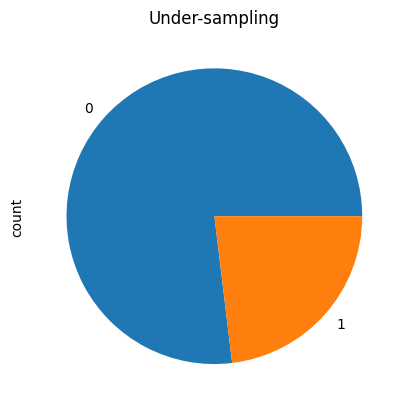

In [34]:
from imblearn.under_sampling import RandomUnderSampler

sampling_strategy = 0.3
rus = RandomUnderSampler(sampling_strategy=sampling_strategy)
X_res, y_res = rus.fit_resample(X, y)
ax = y_res.value_counts().plot.pie()
_ = ax.set_title("Under-sampling")
X_res.shape, y_res.shape, y_res.sum() / y_res.shape[0] * 100

In [35]:
output_path3 = '/content/drive/MyDrive/dm_fire_prediction/merge/merged_v2_no_duplicates_undersampled_23_77.csv'
df = pd.concat([X_res, y_res], axis=1)
df.to_csv(output_path3, index=False)

In [36]:
df.describe()

,lcccode_label,elevation,COARSE,SAND,SILT,CLAY,BULK,REF_BULK,ORG_CARBON,PH_WATER,...,tmax_summer,tmax_winter,tmin_autumn,tmin_spring,tmin_summer,tmin_winter,TEXTURE_SOTER_C,TEXTURE_SOTER_F,TEXTURE_SOTER_M,fire
count,17086.000000,17086.000000,17086.000000,17086.000000,17086.000000,17086.000000,17086.000000,17086.000000,17086.000000,17086.000000,...,17086.000000,17086.000000,17086.000000,17086.000000,17086.00000,17086.000000,17086.000000,17086.000000,17086.000000,17086.000000
mean,9.794861,521.196243,11.362677,49.435558,30.902894,19.661547,1.429252,1.692953,0.890914,7.726317,...,38.203090,17.420403,15.808674,13.072633,23.49602,5.349116,0.027742,0.024933,0.947325,0.230774
std,7.640633,340.763833,3.916829,9.350277,4.370844,6.222856,0.045792,0.083506,0.451932,0.469641,...,4.561711,3.445697,2.700584,3.289405,3.68624,1.932858,0.164238,0.155925,0.223390,0.421340
min,0.000000,-30.000000,2.000000,15.000000,11.300000,9.200000,1.110000,1.406000,0.361000,4.960000,...,27.000000,7.000000,8.000000,5.000000,14.00000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.000000,249.000000,9.200000,42.100000,27.500000,16.000000,1.410000,1.644000,0.639700,7.730000,...,34.000000,15.000000,14.000000,10.000000,20.00000,4.000000,0.000000,0.000000,1.000000,0.000000
50%,7.000000,470.000000,12.000000,51.900000,30.900000,17.100000,1.430000,1.662000,0.701200,7.800000,...,39.000000,18.000000,16.000000,14.000000,24.00000,5.000000,0.000000,0.000000,1.000000,0.000000
75%,18.000000,731.000000,14.300000,57.500000,33.900000,20.900000,1.448000,1.725000,0.884500,7.990000,...,42.000000,20.000000,18.000000,16.000000,27.00000,7.000000,0.000000,0.000000,1.000000,0.000000
max,21.000000,1950.000000,37.600000,79.500000,45.200000,54.000000,1.760000,2.030000,4.192600,8.600000,...,46.000000,25.000000,21.000000,19.000000,30.00000,11.000000,1.000000,1.000000,1.000000,1.000000
